# %% [markdown]

 # Importowanie bibliotek

In [ ]:
import numpy as np
from sklearn.datasets import make_moons,make_classification,make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

In [ ]:
#%%

class AnalyticalRidgeClassifier:
    def __init__(self,alpha) -> None:
        self.alpha=alpha
    def fit(self,X,t):
        I=np.eye(X.shape[1])#Macierz jednostkowa
        self.w=np.linalg.inv(X.T@X +self.alpha*I)@X.T@t #Obliczana Theta

    def predict(self,X_test):
        # return np.sign(X_scaled@self.w) #Bardzo słabe wyniki, accuracy ok. 48%
        return  np.round(1 / (1 + np.exp(-X_test @ self.w)))
    def decision_function(self, X_test):
        y_score = 1 / (1 + np.exp(-X_test @ self.w))
        return y_score

#%% [markdown]

 # Zadanie na 3
 ### Przygotowanie próbek

In [ ]:
indeks=254479
iterations=100
X,y=make_classification(n_samples=2579,n_features=2,n_informative=2, n_redundant=0, n_clusters_per_class=1,random_state=indeks)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
alpha=0.01
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def log_classifier_time(func): #Dekorator do mierzenia czasu klasyfikowania 
    def wrapper(*args,**kwargs):
        start_time=time.time()
        for _ in range(iterations):
            result=func(*args,**kwargs)
        end_time=time.time()-start_time
        print(f"Czas wykonywania {iterations} iteracji wyniósł {end_time:.6f} sekund")
        return result
    return wrapper
def display_classifier_details(y_pred,y_test,name):
    tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
    sensitivity=tp/(tp+fp)
    specificity=tn/(tn+fn)

    print(f"""{name}\n
          \taccuracy: {accuracy_score(y_test,y_pred)}\n
          \tsensitivity: {sensitivity}\n
          \tspecificity: {specificity}
        """)
def plot_roc_curve(y_test,y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'Krzywa ROC - AUC={roc_auc}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.title("Krzywa ROC")
    plt.show()

#%% [markdown]

 # Zadanie na 3
 ### Ręczna implementacja ridge classification

Czas wykonywania 100 iteracji wyniósł 0.018998 sekund
Ręczna implementacja ridge classification

          	accuracy: 0.8746770025839793

          	sensitivity: 0.8506024096385543

          	specificity: 0.9025069637883009
        


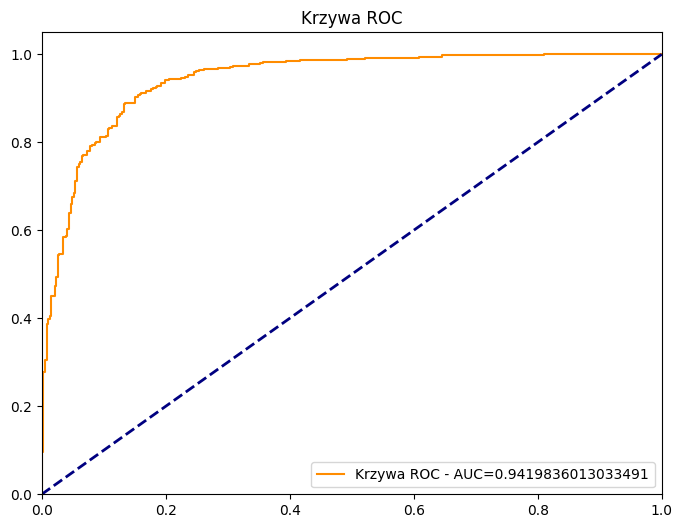

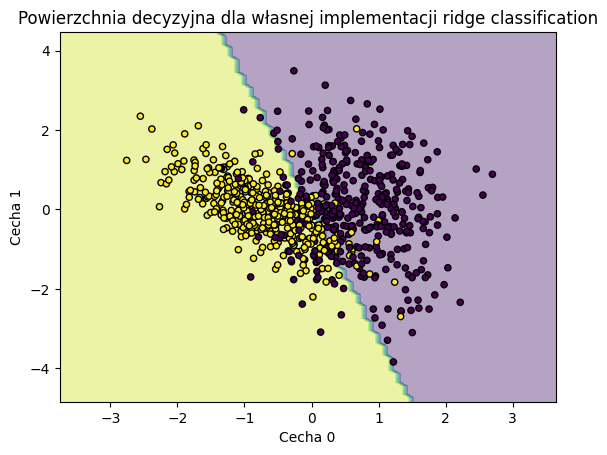

In [ ]:
@log_classifier_time
def classify_analytically(): # Klasyfikacja analityczna
    classifier=AnalyticalRidgeClassifier(alpha)
    classifier.fit(X_train,y_train)
    y_analytic_pred=classifier.predict(X_test)
    return (y_analytic_pred,classifier)

y_pred,clf=classify_analytically()

y_score=clf.decision_function(X_test)

display_classifier_details(y_pred,y_test,"Ręczna implementacja ridge classification")

plot_roc_curve(y_test,y_score)


x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Powierzchnia decyzyjna dla własnej implementacji ridge classification')
plt.xlabel('Cecha 0')
plt.ylabel('Cecha 1')
plt.show()

#%% [markdown]

 # Zadanie na 3
 ### Implementacja scikit ridge classification

Czas wykonywania 100 iteracji wyniósł 0.291229 sekund
Ridge classification z z modułu sklearn

          	accuracy: 0.875968992248062

          	sensitivity: 0.8543689320388349

          	specificity: 0.9005524861878453
        


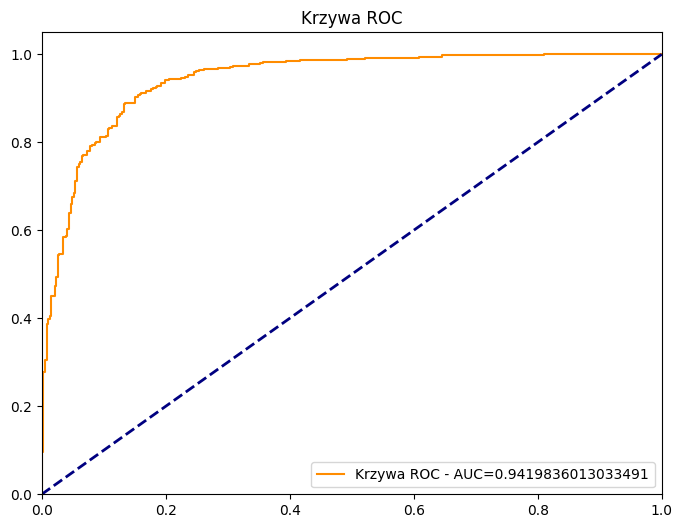

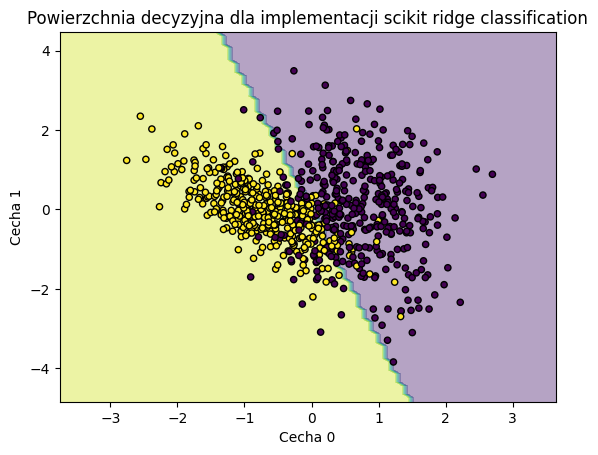

In [ ]:
@log_classifier_time
def classify_with_scikit():
    classifier=RidgeClassifier(alpha=alpha)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    
    return (classifier,y_pred)

clf,y_pred=classify_with_scikit()

display_classifier_details(y_pred,y_test,"Ridge classification z z modułu sklearn")
y_score=clf.decision_function(X_test)

plot_roc_curve(y_test,y_score)

x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Powierzchnia decyzyjna dla implementacji scikit ridge classification')
plt.xlabel('Cecha 0')
plt.ylabel('Cecha 1')
plt.show()

#%%[markdown]

 Obie implementacje dają bardzo podobne wyniki

#%% [markdown]

 # Zadanie na 4
 W pliku HeartCleveland brakuje 6 cech, rzędy zawierające te cechy zostały usunięte, zmienną przewidywaną zastąpiono zmienną binarną
 Do klasyfikacji wybrano cechy 9, 11, 8 i 12, ponieważ mają najwyższe współczynniki Pearsona z targetem

#%%[markdown]

 # Wczytanie danych

In [ ]:
cleveland=np.loadtxt("HeartCleveland.csv",delimiter=",")

#%%[markdown]

 # Zadanie na 4
 #### Obliczanie podstawowych miar statystycznych dla wszystkich cech

In [ ]:
categorical=[1,2,5,6,8,10,12]


for i in range(cleveland[:,:-1].shape[1]):
    output=f"Cecha {i}:\n"
    if i in categorical:#dla wartości kategorycznych
        output+=f"\tDominanta: {stats.mode(cleveland[:,i])[0][0]}\n"
    else:#dla wartości ciągłych
        output+=f"\tŚrednia: {np.mean(cleveland[:,i])}\n"
        output+=f"\tOdchylenie standardowe: {np.std(cleveland[:,i])}\n"

    output+=f"\tMin: {np.min(cleveland[:,i])}\n\tMax: {np.max(cleveland[:,i])}"
    print(output)

Cecha 0:
	Średnia: 54.54208754208754
	Odchylenie standardowe: 9.034487589926636
	Min: 29.0
	Max: 77.0
Cecha 1:
	Dominanta: 1.0
	Min: 0.0
	Max: 1.0
Cecha 2:
	Dominanta: 4.0
	Min: 1.0
	Max: 4.0
Cecha 3:
	Średnia: 131.69360269360268
	Odchylenie standardowe: 17.73287743823472
	Min: 94.0
	Max: 200.0
Cecha 4:
	Średnia: 247.35016835016836
	Odchylenie standardowe: 51.909970707892114
	Min: 126.0
	Max: 564.0
Cecha 5:
	Dominanta: 0.0
	Min: 0.0
	Max: 1.0
Cecha 6:
	Dominanta: 0.0
	Min: 0.0
	Max: 2.0
Cecha 7:
	Średnia: 149.5993265993266
	Odchylenie standardowe: 22.90290733792757
	Min: 71.0
	Max: 202.0
Cecha 8:
	Dominanta: 0.0
	Min: 0.0
	Max: 1.0
Cecha 9:
	Średnia: 1.0555555555555556
	Odchylenie standardowe: 1.1641579568929132
	Min: 0.0
	Max: 6.2
Cecha 10:
	Dominanta: 1.0
	Min: 1.0
	Max: 3.0
Cecha 11:
	Średnia: 0.6767676767676768
	Odchylenie standardowe: 0.9373824451006205
	Min: 0.0
	Max: 3.0
Cecha 12:
	Dominanta: 3.0
	Min: 3.0
	Max: 7.0


<ipython-input-93-bec801afb40b>:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  output+=f"\tDominanta: {stats.mode(cleveland[:,i])[0][0]}\n"


#%% [markdown]

 # Zadanie na 4
 #### Wyświetlenie histogramów cech pacjentów

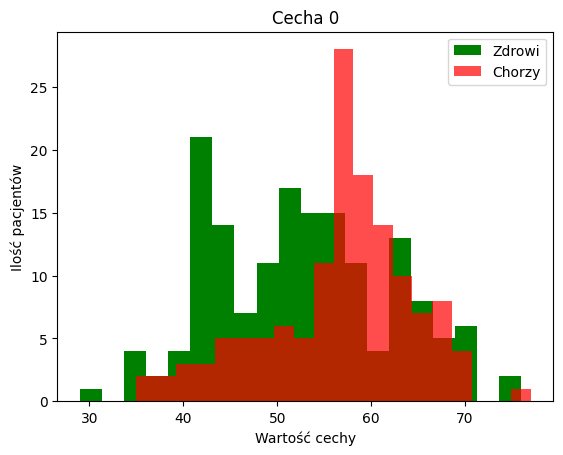

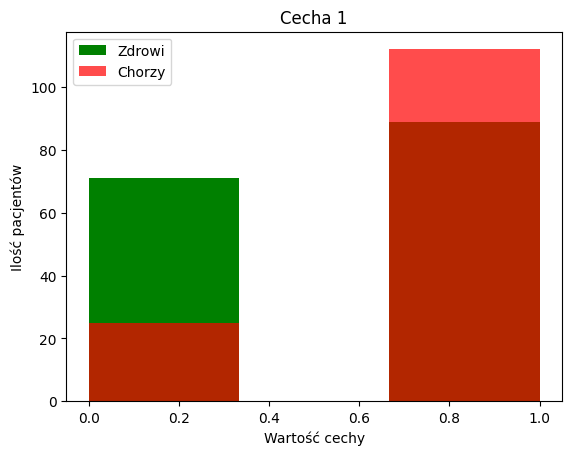

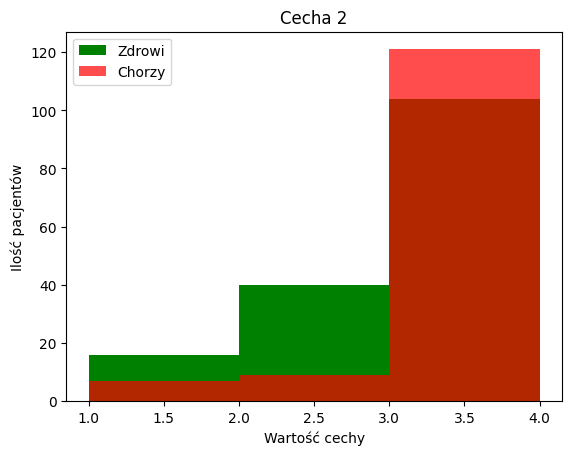

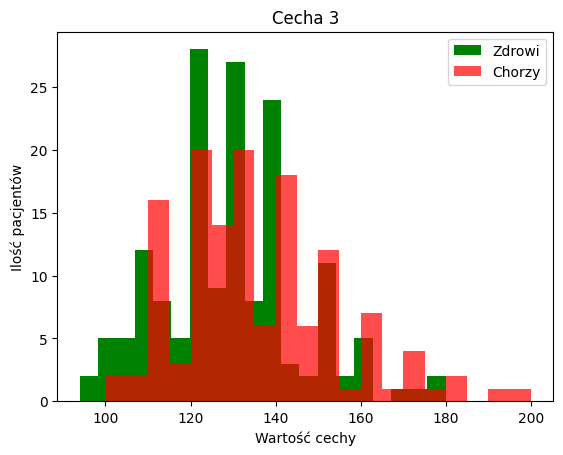

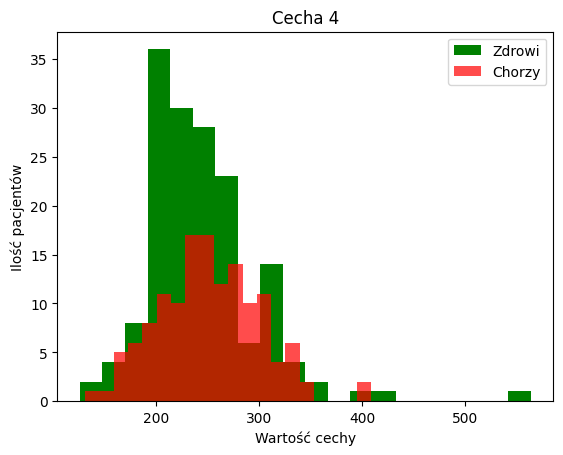

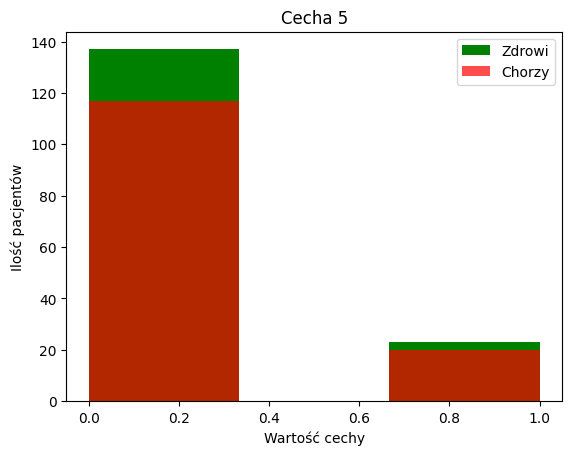

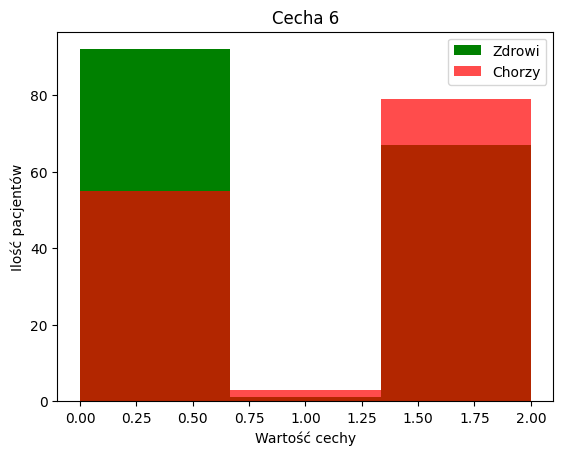

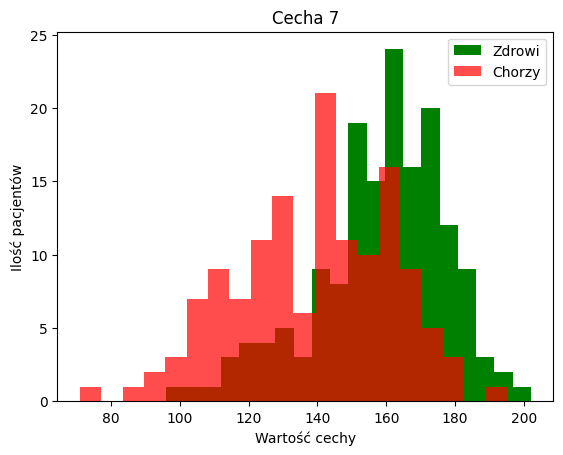

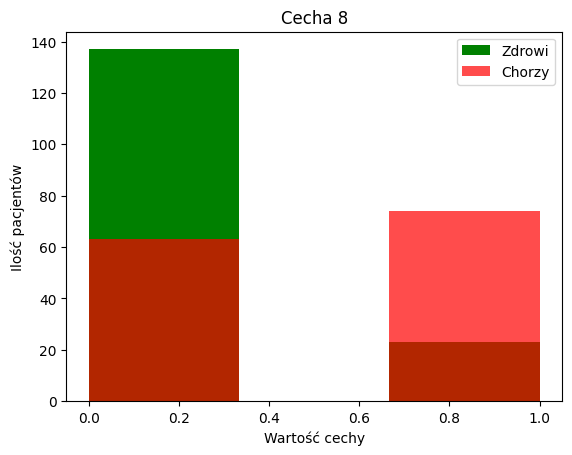

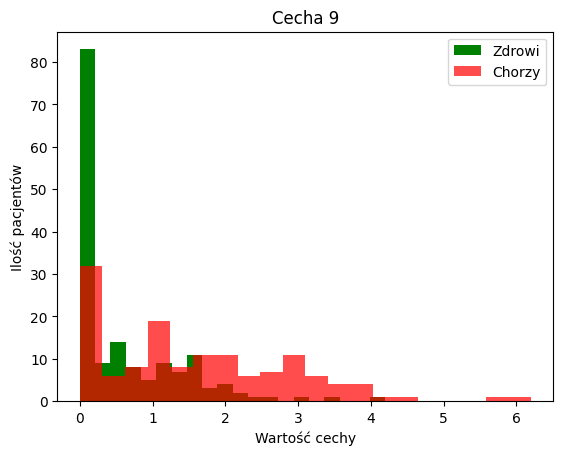

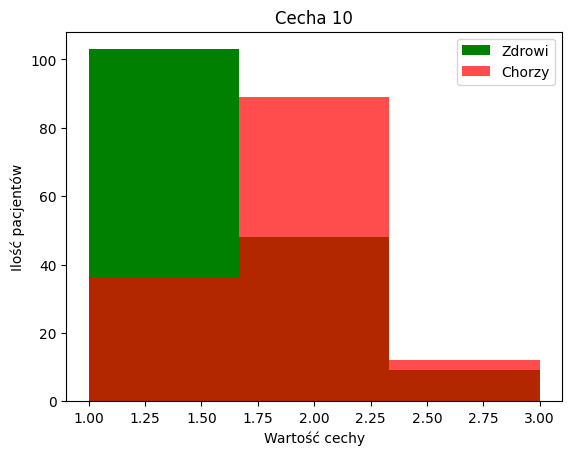

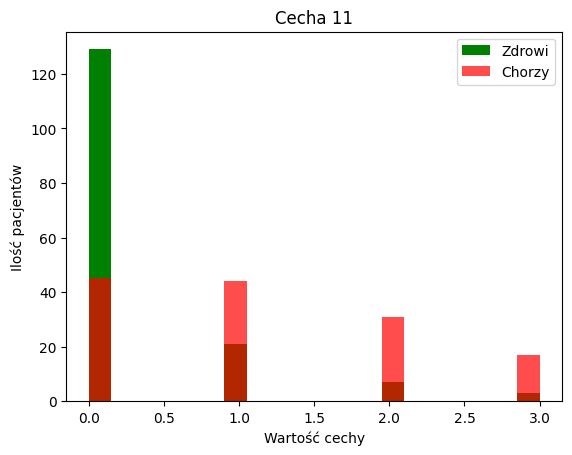

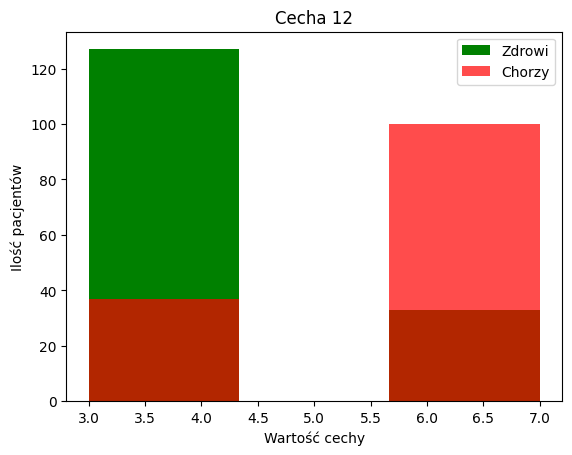

In [ ]:
for i in range(cleveland[:,:-1].shape[1]):
    bins=20
    if(i in categorical):
        bins=3
    plt.hist(cleveland[cleveland[:,-1]==0][:,i],bins=bins,label="Zdrowi",color="green")
    plt.hist(cleveland[cleveland[:,-1]==1][:,i],bins=bins,label="Chorzy",alpha=0.7,color="red")
    plt.legend()
    plt.xlabel("Wartość cechy")
    plt.ylabel("Ilość pacjentów")
    plt.title(f"Cecha {i}")
    plt.show()

#%%[markdown]

 # Zadanie na 4
 #### Obliczenie macierzy korelacji i jej wyświetlenie
 #### Ręczny wybór 4 najlepszych cech do klasyfikacji

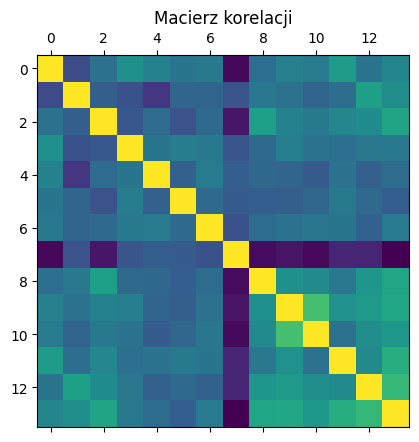

Cecha 0 - 0.22707515465323647
Cecha 1 - 0.2784666966537959
Cecha 2 - 0.4089446866752393
Cecha 3 - 0.15349002570252002
Cecha 4 - 0.08028475098000232
Cecha 5 - 0.0031668297708802823
Cecha 6 - 0.1663434881660239
Cecha 7 - -0.4238170641833712
Cecha 8 - 0.42135549045645315
Cecha 9 - 0.4240520567159986
Cecha 10 - 0.3330491087395562
Cecha 11 - 0.4631886250630227
Cecha 12 - 0.5266395760779844
Cecha 13 - -3.0
Cechy o największych współczynnikach korelacji z targetem to: 12,11,9,8


In [ ]:
cor=np.corrcoef(cleveland,rowvar=False) # macierz korelacji

plt.matshow(cor)
plt.title("Macierz korelacji")
plt.show()
def display_target_correlations(cor):

    cor2=cor-4*np.eye(cor.shape[0])
    for i,c in enumerate(cor2[:,-1]):
        print(f"Cecha {i} - {c}")
    print("Cechy o największych współczynnikach korelacji z targetem to: 12,11,9,8")

display_target_correlations(cor)

#%%[markdown]

 # Zadanie na 5
 #### Przygotowanie próbek

In [ ]:
alpha=0.001
new_cleveland=np.c_[cleveland[:,9],cleveland[:,11],cleveland[:,8],cleveland[:,12]]

X=new_cleveland
y=cleveland[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#%% [markdown]

 # Zadanie na 5
 #### Własna implementacja dla ręcznie wybranych cech

Czas wykonywania 100 iteracji wyniósł 0.019196 sekund
Własna implementacja dla ręcznie wybranych cech

          	accuracy: 0.8666666666666667

          	sensitivity: 0.8918918918918919

          	specificity: 0.8490566037735849
        


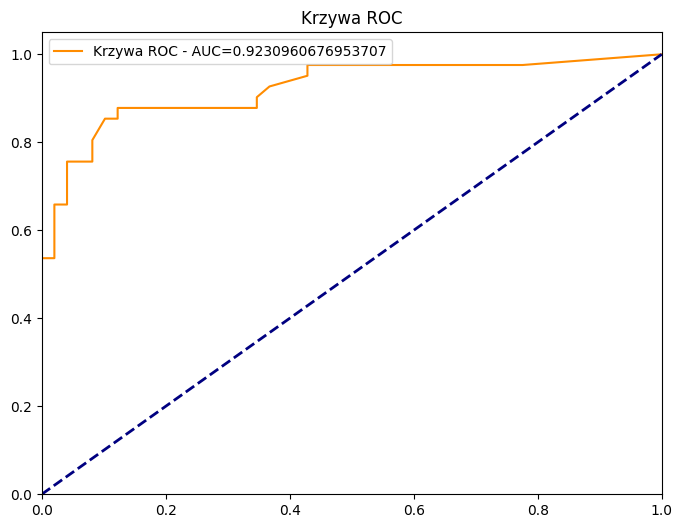

In [ ]:
@log_classifier_time
def analytical_classification():
    cl=AnalyticalRidgeClassifier(alpha) 
    cl.fit(X_train,y_train)
    y_pred=cl.predict(X_test)
    return (y_pred,cl)

y_pred,clf=analytical_classification()
y_score=clf.decision_function(X_test)
display_classifier_details(y_pred,y_test,"Własna implementacja dla ręcznie wybranych cech")
plot_roc_curve(y_test,y_score)

#%% [markdown]

 # Zadanie na 5
 #### Implementacja scikit dla ręcznie wybranych cech

Czas wykonywania 100 iteracji wyniósł 0.398806 sekund
Implementacja scikit dla ręcznie wybranych cech

          	accuracy: 0.8444444444444444

          	sensitivity: 0.8857142857142857

          	specificity: 0.8181818181818182
        


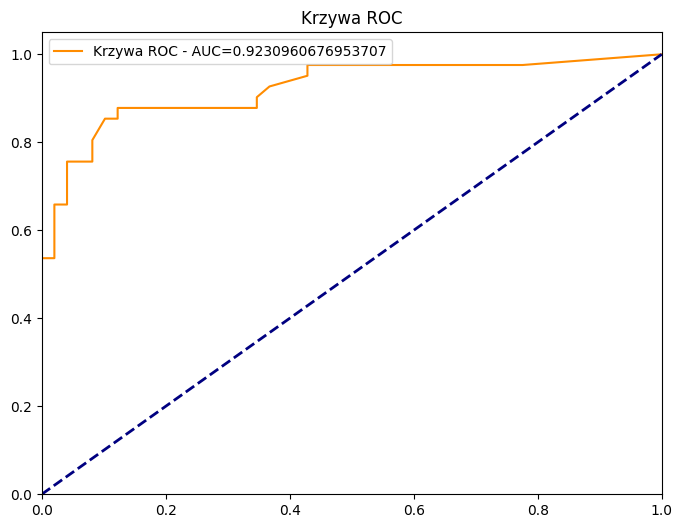

In [ ]:
@log_classifier_time
def sklearn_classication():
    cl=RidgeClassifier(alpha)
    cl.fit(X_train,y_train)
    y_pred=cl.predict(X_test)
    y_score=cl.decision_function(X_test)

    return (y_pred,y_score)

y_pred,y_score=sklearn_classication()

display_classifier_details(y_pred,y_test,"Implementacja scikit dla ręcznie wybranych cech")
plot_roc_curve(y_test,y_score)

#%% [markdown] 

 # Zadanie na 5
 #### Przygotowanie próbek, automatyczny wybór cech

In [ ]:
X=cleveland[:,:-1]
y=cleveland[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

cl=RidgeClassifier(alpha)
sfs=SequentialFeatureSelector(cl,n_features_to_select=4)
sfs.fit(X_train,y_train)
features=sfs.get_support()
print("Wybrano cechy: ")
for i,feature in enumerate(features):
    if feature:
        print(f"-Cecha {i}") 
X=X[:,features]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Wybrano cechy: 
-Cecha 0
-Cecha 1
-Cecha 6
-Cecha 11


#%% [markdown]

 # Zadanie na 5
 #### Własna implementacja dla automatycznie wybranych cech

Czas wykonywania 100 iteracji wyniósł 0.019387 sekund
Własna implementacja dla automatycznie wybranych cech

          	accuracy: 0.7333333333333333

          	sensitivity: 0.7741935483870968

          	specificity: 0.711864406779661
        


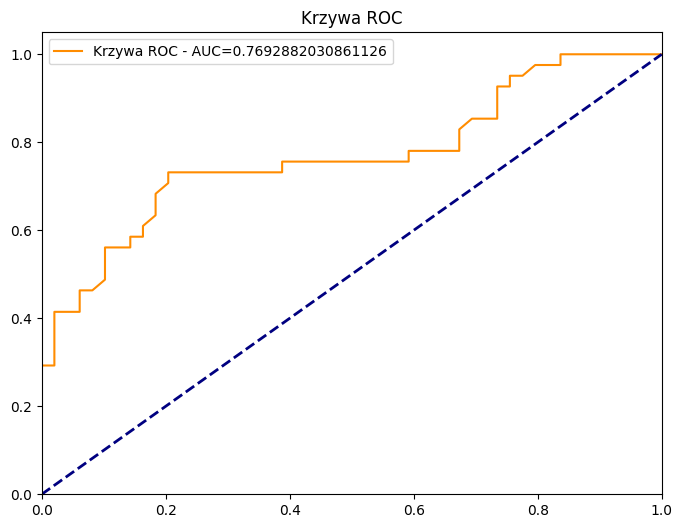

In [ ]:
@log_classifier_time
def analytical_classification2():
    cl=AnalyticalRidgeClassifier(alpha)
    cl.fit(X_train,y_train)
    y_predict=cl.predict(X_test)
    y_score=cl.decision_function(X_test)
    return (y_predict,y_score)
y_predict,y_score=analytical_classification2()
display_classifier_details(y_predict,y_test,"Własna implementacja dla automatycznie wybranych cech")
plot_roc_curve(y_test,y_score)

#%% [markdown]

 # Zadanie na 5
 #### Implementacja scikit dla automatycznie wybranych cech

Czas wykonywania 100 iteracji wyniósł 0.282557 sekund
Implementacja scikit dla automatycznie wybranych cech

          	accuracy: 0.7222222222222222

          	sensitivity: 0.7666666666666667

          	specificity: 0.7
        


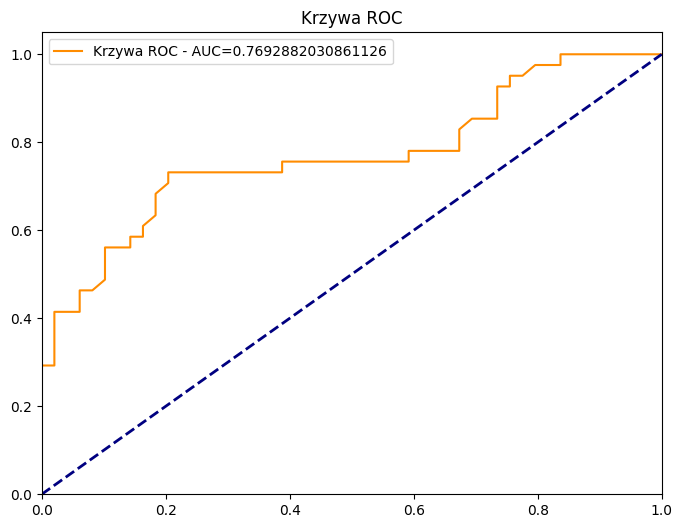

In [ ]:
@log_classifier_time
def sklearn_classfication2():
    cl=RidgeClassifier(alpha)
    cl.fit(X_train,y_train)
    y_pred=cl.predict(X_test)
    y_score=cl.decision_function(X_test)

    return (y_pred,y_score)
y_predict,y_score=sklearn_classfication2()
display_classifier_details(y_predict,y_test,"Implementacja scikit dla automatycznie wybranych cech")
plot_roc_curve(y_test,y_score)

#%% [markdown]

 # Zadanie na 5
 #### Własna implementacja dla wszystkich cech

Czas wykonywania 100 iteracji wyniósł 0.025197 sekund
Własna implementacja dla wszystkich cech

          	accuracy: 0.9

          	sensitivity: 0.9

          	specificity: 0.9
        


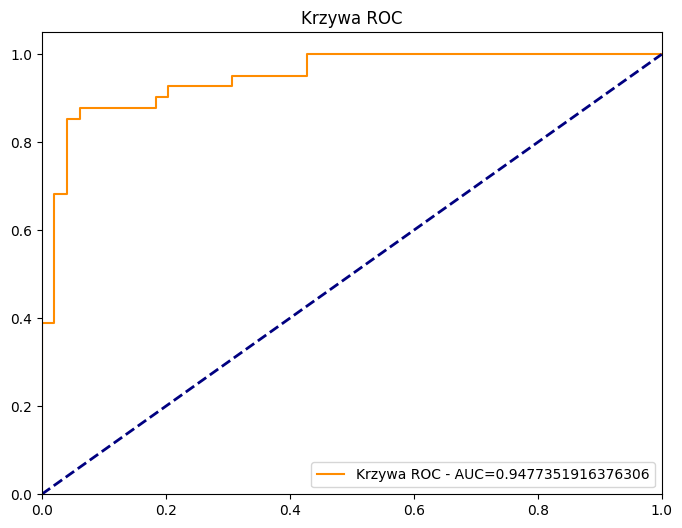

In [ ]:
X=cleveland[:,:-1]
y=cleveland[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

@log_classifier_time
def analytical_classification3():
    cl=AnalyticalRidgeClassifier(alpha)
    cl.fit(X_train,y_train)
    y_predict=cl.predict(X_test)
    y_score=cl.decision_function(X_test)
    return (y_predict,y_score)
y_predict,y_score=analytical_classification3()
display_classifier_details(y_predict,y_test,"Własna implementacja dla wszystkich cech")
plot_roc_curve(y_test,y_score)

#%% [markdown]

 # Zadanie na 5
 #### Implementacja scikit dla wszystkich cech

Czas wykonywania 100 iteracji wyniósł 0.285011 sekund
Implementacja scikit dla wszystkich cech

          	accuracy: 0.9

          	sensitivity: 0.9210526315789473

          	specificity: 0.8846153846153846
        


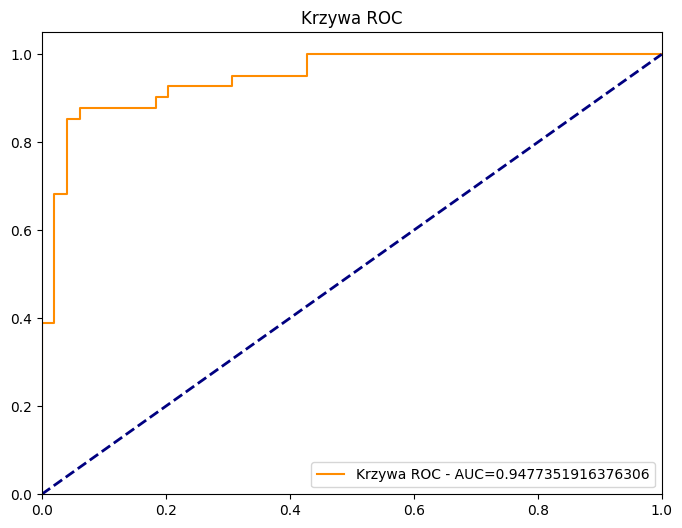

In [ ]:
@log_classifier_time
def sklearn_classfication3():
    cl=RidgeClassifier(alpha)
    cl.fit(X_train,y_train)
    y_pred=cl.predict(X_test)
    y_score=cl.decision_function(X_test)

    return (y_pred,y_score)

y_predict,y_score=sklearn_classfication3()
display_classifier_details(y_predict,y_test,"Implementacja scikit dla wszystkich cech")
plot_roc_curve(y_test,y_score)